In [1]:

# Incomelyzer: Insightful salary analysis + prediction in one notebook

# ## 1. Data Loading
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import joblib

# Load Dataset
file_path = 'adult 3.csv'
data = pd.read_csv(file_path)
data.head()


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [2]:

# ## 2. Data Cleaning
# Replace '?' and filter rows
data['occupation'] = data['occupation'].replace({'?': 'Not-Listed'})
data['workclass'] = data['workclass'].replace({'?': 'Not-Listed'})
data = data[data['workclass'].isin(['Private','Self-emp-not-inc','Self-emp-inc','Federal-gov','Local-gov','State-gov','Not-Listed'])]
data = data[data['education'].isin(['Some-college', 'HS-grad', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Masters', 'Doctorate'])]
data.drop(columns=['education'], inplace=True)
data = data[(data['age'].between(17, 75)) & (data['educational-num'].between(5, 16)) & (data['hours-per-week'].between(1, 80))]


In [3]:

# ## 3. Label Encoding
from sklearn.preprocessing import LabelEncoder
label_cols = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
le = LabelEncoder()
for col in label_cols:
    data[col] = le.fit_transform(data[col])


In [4]:

# ## 4. Feature Scaling
X = data.drop(columns=['income'])
y = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [5]:

# ## 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [6]:

# ## 6. Model Training with Multiple Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True),
    "GradientBoosting": GradientBoostingClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\n✅ Best model: {best_model_name} with accuracy {results[best_model_name]:.4f}")


LogisticRegression: 0.8087
RandomForest: 0.8464
KNN: 0.8096
SVM: 0.8363
GradientBoosting: 0.8589
DecisionTree: 0.8046
XGBoost: 0.8616

✅ Best model: XGBoost with accuracy 0.8616


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:34:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [7]:

# ## 7. Save Best Model and Scaler
joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("✅ Model and Scaler saved successfully.")


✅ Model and Scaler saved successfully.


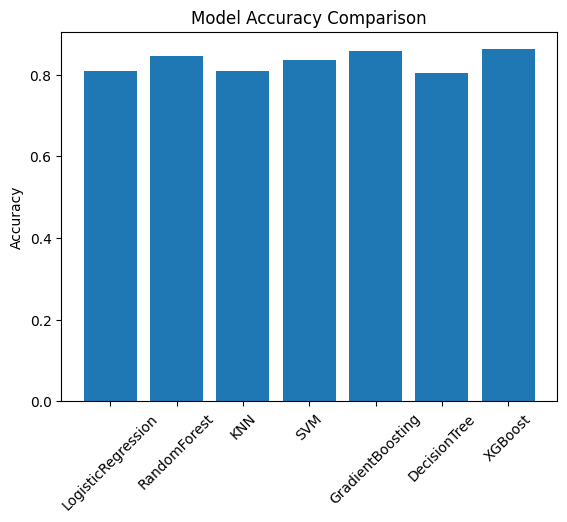

In [8]:

# ## 8. Final Comparison Plot
import matplotlib.pyplot as plt
plt.bar(results.keys(), results.values())
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()


In [9]:

# ## 9. Conclusion
print("Incomelyzer completes salary prediction using multiple algorithms with best accuracy achieved using", best_model_name)


Incomelyzer completes salary prediction using multiple algorithms with best accuracy achieved using XGBoost


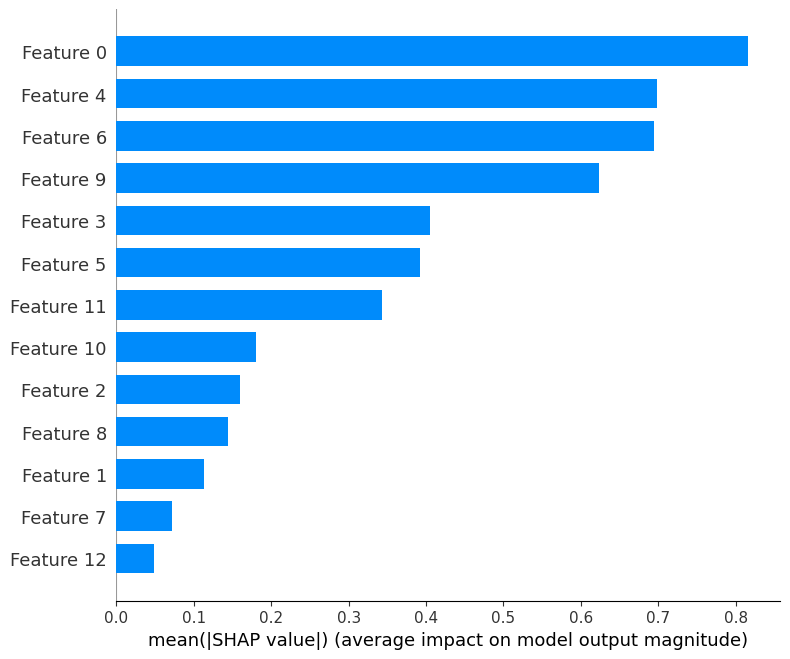

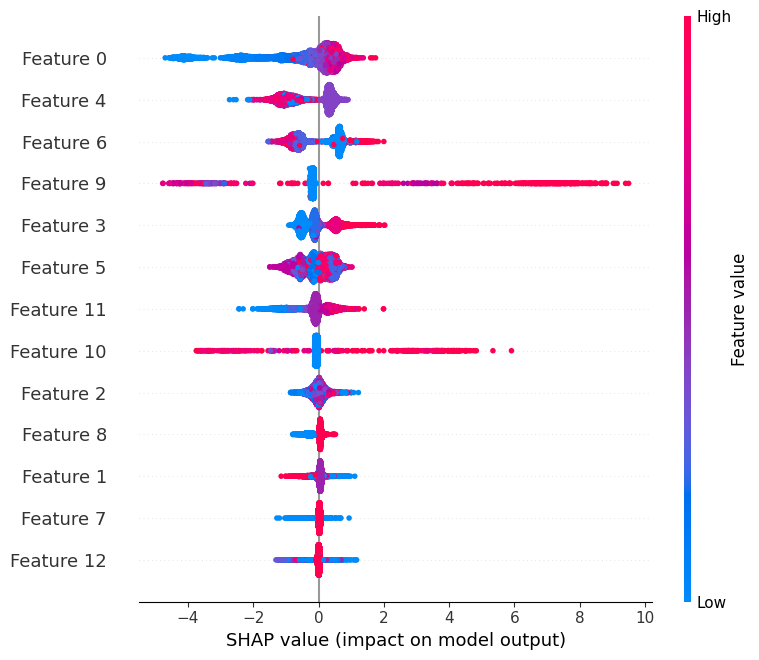

In [11]:
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")  # Bar plot
shap.summary_plot(shap_values, X_test)  # Detailed beeswarm plot
